In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import torch 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())


train, valid = random_split(train_dataset,[50000,10000])

In [3]:
NUM_EPOCHS = 100
EARLY_STOP = 10
NUM_CLASS = 10
BATCH_SIZE = 100
LEARN_RATE = 0.001

In [4]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train,
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid,
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False)

In [5]:
class CNN_model(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_model, self).__init__()
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc = torch.nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [6]:
model = CNN_model(NUM_CLASS).to(device)

cost_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE)
print(model)

CNN_model(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


In [7]:
ACC,LOSS,VAL_ACC,VAL_LOSS = [],[],[],[]

early_step, total_step = 0, len(train_loader)
min_valid_loss = np.inf

def calculate_acc(outputs, labels, total, correct):
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    return total,correct
    
for epoch in range(NUM_EPOCHS):    
    train_acc,train_total,valid_acc,valid_total = 0,0,0,0
    train_loss,valid_loss = 0.0,0.0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = cost_func(outputs, labels)
        train_total, train_acc = calculate_acc(outputs, labels, train_total, train_acc)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = cost_func(outputs, labels)
        valid_total, valid_acc = calculate_acc(outputs, labels, valid_total, valid_acc)
        valid_loss += loss.item()  
    
    ACC.append(train_acc/train_total)
    LOSS.append(train_loss)
    VAL_ACC.append(valid_acc/valid_total)
    VAL_LOSS.append(valid_loss)
    
    print('Epoch[{:2d}/{}]\n             train_acc: {:5.2f} | train_loss: {:6.3f} | valid_acc: {:5.2f} | valid_loss: {:6.3f}'.format(epoch+1,NUM_EPOCHS,100*(train_acc/train_total),(train_loss /len(train_loader)),100*(valid_acc/valid_total),(valid_loss /len(valid_loader))))
    
    if min_valid_loss > valid_loss:
        print('\n             Validation loss decreased({:4f}--->{:4f})...saving model'.format(min_valid_loss,valid_loss))
        
        early_step, min_valid_loss = 0, valid_loss     
        torch.save(model.state_dict(), 'saved_model.pth')
    else:
        early_step += 1
        if early_step > EARLY_STOP:
            print(f"No improvment {EARLY_STOP} consecutive epochs, early stopping.")
            break

Epoch[ 1/100]
             train_acc: 95.61 | train_loss:  0.152 | valid_acc: 98.19 | valid_loss:  0.062

             Validation loss decreased( inf--->6.193310)...saving model
Epoch[ 2/100]
             train_acc: 98.41 | train_loss:  0.051 | valid_acc: 98.47 | valid_loss:  0.050

             Validation loss decreased(6.193310--->5.015289)...saving model
Epoch[ 3/100]
             train_acc: 98.79 | train_loss:  0.039 | valid_acc: 98.13 | valid_loss:  0.059
Epoch[ 4/100]
             train_acc: 99.06 | train_loss:  0.030 | valid_acc: 98.78 | valid_loss:  0.040

             Validation loss decreased(5.015289--->4.048868)...saving model
Epoch[ 5/100]
             train_acc: 99.17 | train_loss:  0.026 | valid_acc: 98.78 | valid_loss:  0.041
Epoch[ 6/100]
             train_acc: 99.29 | train_loss:  0.022 | valid_acc: 98.46 | valid_loss:  0.050
Epoch[ 7/100]
             train_acc: 99.45 | train_loss:  0.018 | valid_acc: 98.69 | valid_loss:  0.042
Epoch[ 8/100]
             train_acc: 

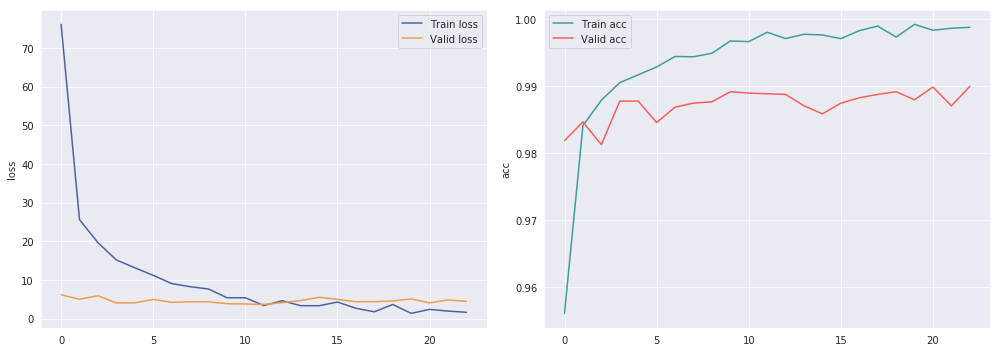

In [8]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(LOSS, label="Train loss", color="#4863A0")
ax[0].plot(VAL_LOSS, label="Valid loss", color="#EE9A4D")
ax[0].set_ylabel('loss')
ax[0].legend(loc="upper right")

ax[1].plot(ACC, label="Train acc", color="#3B9C9C")
ax[1].plot(VAL_ACC, label="Valid acc", color="#F75D59")
ax[1].set_ylabel('acc')
ax[1].legend(loc="upper left")

plt.tight_layout()
plt.show()

In [9]:
model = CNN_model(NUM_CLASS).to(device)
model.load_state_dict(torch.load('saved_model.pth'))
model.eval()  

def calculate_acc(outputs, labels, total, correct):
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    return total,correct

with torch.no_grad():
    acc,total = 0,0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        total, acc = calculate_acc(outputs, labels, total, acc)
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100*acc/total))

Test Accuracy of the model on the 10000 test images: 99.12 %
